[How to submit demo] 참조.  
https://pennylane.ai/qml/demos_submission.html  
[주피터 노트북으로 쓴 demo 예시]  
https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html  
[사진 넣는 방법(그냥 넣으면 깨지더라고)]  
https://medium.com/analytics-vidhya/embedding-your-image-in-google-colab-markdown-3998d5ac2684

In [7]:
%%capture 
pip install pennylane

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.autograd import Variable

# **Variatioanl quantum evolution equation solver**
*Author: 신명진, 이민규, 이준서 and 여현준 --- Date: 28 February 2023.*

This demo dicribes how to solve the time evolution partial differential equation using variatoinal algorithm and Hamiltonian evolution. (Unlike other quantum differential equation solver algorithms using quantum algorithm for linear systems of equations; HHL) This example is based on  [Fong Yew Leong, Wei-Bin Ewe & Dax Enshan Koh (25 June 2022)](https://www.nature.com/articles/s41598-022-14906-3)






## **Background**
---
There is still a lot of time left before the creation of fault-tolerant quantum computer, which is thought to surpass classical computers in many ways including cryptography, quantum simulation and combinatorial problems. The most popular algorithm in the Noisy Intermediate Scale Quantum era(NISQ), a bridge to the fault-tolerant quantum computer is a variational quantum algorithm(VQA) which is a mixture of classical and quantum computer. VQA is considered suitable for NISQ because it reduces the load of quantum hardware.

### **Variational quantum algorithm** 
VQA refers to the entire algorithm that uses the variational principle. In quantum mechanics, variational principle means arbitrary wavefunction's energy cannot be smaller than the ground state's energy. 
$$For~~|\psi\rangle=\sum_i a_i|\psi_i\rangle,~~E_{gs}\leq \sum_i a_iE_i$$ 
By this principle we can make parametrized wavefuncion's energy converges to the minimum. This priniciple can be used for most other optimization problems other than quantum mechanics. Most VQA consists of following processes.
> 1. Preparing appropriate initial parametrized quantum state $|\psi(\theta)\rangle$(ansatz)  
2. Determine the cost function you want to minimize and obtain it through a quantum computer(ex. In the case of finding ground state, cost function is $\langle\psi|H|\psi\rangle$)  
3. Find a new parameter that reduces cost function using a clssical computer  
4. Back to the process 1 and repeat this above process until the cost function coverges  

In this demo, we are going to solve the heat equation(time-dependent partial differential equation) by variational algorithm in a similar way as above.

### **Numerical method for solving differential equations**
Differential equations can be used to describe systems in various fields such as physical equation(Maxwell's equation and Schrödinger equation), economical system and biological system. However we cannot find analytic solution of most differential equations. So we have to solve it by numerical method using computer. There are several ways to solve differential equation. In this example, we're going to use [finite difference method(FDM)](https://www.ljll.math.upmc.fr/frey/cours/UdC/ma691/ma691_ch6.pdf).

FDM approximates derivatives using taylor expansion. For analytic function $f$, taylor expansion of this function and its derivative is
$$f(x_0+h)=f(x_0)+\frac{f'(x_0)}{1!}h+\frac{f''(x_0)}{2!}h^2+\dotsi~$$
$$f'(x_0)\approx \frac{f(x_0+h)-f(x_0)}{h}.$$ 
Since computer cannot deal with continuous domain, we have to discretize function's domain to solve equation numerically. For example, let function $f:[0, 1]\rightarrow\mathbb{R}$ which satisfies $\frac{d^2f}{dx^2}=2x$. If we split the domain into 40 sections, then domain will be the set $X=\{x_0=0, x_1, x_2, \dotsi, x_{40}=1\}$ and the function f will be a discrete function $f^D:X\rightarrow \mathbb{R}$. The second derivative at $x_i$ obtained by combining discretization and FDM is as follows. Let $\Delta x=x_i-x_{i-1}=0.025$.
$$Analogy~of~\frac{d^2f}{dx^2}|_{x=x_i}=\frac{f^D(x_{i+1})-2f^D(x_i)+f^D(x_{i-1})}{(\Delta x)^2}~~for~i=1, 2,\dotsi, 39$$
But the boundary conditions of differential equations must be addresed in particular. Let the boundary condition of this problem is $f(x_0)=0, f(x_{40})=1$ (Dirichlet condition). 
If we combine all of the above linear equations, the differential equation becomes the matrix equation below. (Boundary conditions can also be expressed in other ways in matrix equations.)
<p align="center"><img src="https://drive.google.com/uc?id=1oDvPSZPLW7W4CqNbn8L3gPS79m9qM7tX"></p>  

Therefore, solving the above matrix equation is the same as solving the differential equation. Here is an numerical example solving above equation.

In [9]:
# Numerical example of solving d^2f/dx^2=2x
x_domain = np.arange(0, 1.001, 0.025)
rhs = x_domain * 2 * (-1) * 0.02**2
rhs[-1] = 1

# Laplacian matrix: L_matrix
L_matrix = np.zeros((41, 41))
L_matrix[0, 0] = 1
L_matrix[-1, -1] = 1
for i in np.arange(1, 40):
        L_matrix[i , i - 1 ] = -1
        L_matrix[i, i] = 2
        L_matrix[i, i + 1] = -1
# Solving matrix equation
f_D = np.linalg.solve(L_matrix, rhs)

# Analytic solution
def f(x):
    return 1/3 * x ** 2 + 2/3 * x
f_A = np.array([])
for i in x_domain:
    f_A = np.append(f_A, f(i))

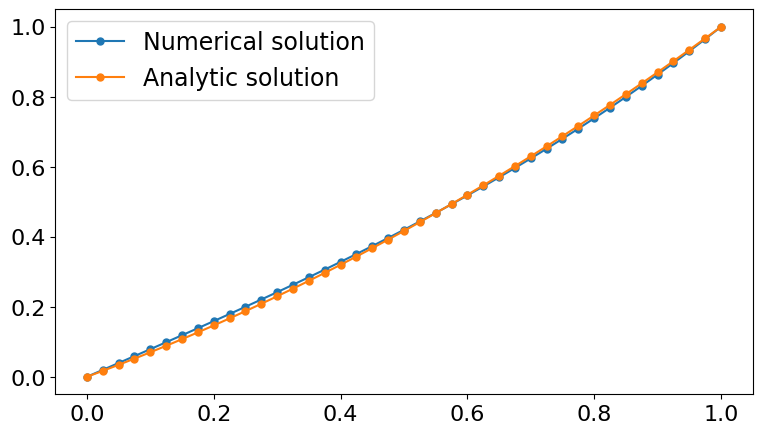

In [10]:
# Compare numerical solution with analytic solution
plt.figure(figsize = (9, 5))
plt.plot(x_domain, f_D, '-o', markersize = 5, label = "Numerical solution")
plt.plot(x_domain, f_A, '-o', markersize = 5, label = "Analytic solution")
plt.legend(fontsize = "17")
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.show()

There are several quantum algorithms for solving differential equation based on a quantum algorithm for linear systems of equations because of the relationship between them. ([Dominic W. Berry, etc., (2017)](https://link.springer.com/article/10.1007/s00220-017-3002-y), [Pedro C. S. Costa, etc. (2019)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.012323)) However, our method using variational algorithm will solve the matrix equation using Hamiltonian evolution.

## **State preparation**
---
One common important job for quantum variational algorithm is the preparation of parametrized ansatz. In this example, we will solve the heat equation by converting it into the following linear systems of equations.
$$D\frac{\partial^2 u}{\partial x^2}=\frac{\partial u}{\partial t}~~\rightarrow~~ A|u\rangle=|b\rangle$$
The above equation is defined on the set $\Omega × J$, where $Ω⊂\mathbb{R}$ denotes a spatial domain and $J=[0, T]$ denotes a temporal domain. A function $u(x, t)$ is the solution what we want, so we have to optimize some parameter set $\theta$ so that our parametrized ansatz $|\psi(\theta)\rangle=U(\theta)|0^{\otimes n}\rangle$ converges to $|u\rangle$.  

If we suppose the solution $u$ be real number, we can make an ansatz of this example consists of $R_y(\theta)$ and CNOT gate since there is no imaginary term in $R_y(\theta)$. When there are n qubits, the parametrized circuit operate as $U(\theta)$ is as follows.

<p align="center"><img src="https://drive.google.com/uc?id=1gBuUchrpmfuvou4pxteivlAoLeCA8Ftv"></p>

In [11]:
n_qubits = 4
# There exist n x n parameters. Check the reference paper's 4p figure1.
# (i, j) component of weights is  the parameter i-th layer, j-th qubit's parameter

# function which makes above figure's circuit
def circuit(weights, n_qubits = 4):
    for i in range(n_qubits):
        for j in range(n_qubits):
            qml.RY(weights[j, i], wires = j) 
        for k in range(n_qubits-1):
            qml.CNOT(wires = [k, k+1])

To get the solution, we have to encode the boundary condition(which we already know) into quantum state and use it. There are various method for quantum encoding. We choose amplitude encoding method, which encodes classical data into the amplitude ofcomputational basis. For example, let us assume that the dirichlet condition is given by ${x_0=0.1, x_1=0.3, x_2=-0.2, x_4=0.1}$. Since amplitude of quantum state has to be normalized, the results of encoding this data are as follows.
$$\frac{1}{\sqrt{0.1^2+0.3^2+0.2^2+0.1^2}}(0.1|00\rangle+0.3|01\rangle-0.2|10\rangle+0.1|11\rangle)$$
The estimated solution is also obtained from the amplitude of $|u\rangle=\sum_{i = 00, 01,\dotsi} a_i|i\rangle$. There is a built-in circuit for amplitude encoding in pennylane, so we used it.

In [12]:
# Amplitude encoding built-in circuit in pennylane
def amplitude_encoding(f, wires=range(4)):
    qml.AmplitudeEmbedding(features=f, wires=wires, normalize = True)

# Example of amplitude encoding
amplitude_example = [1/2, 1/2, 0, 1/np.sqrt(2)]
dev = qml.device("default.qubit", wires = 2)
@qml.qnode(dev)
def example_circuit(wires=range(2)):
    amplitude_encoding(f = amplitude_example, wires=wires)
    return qml.expval(qml.PauliZ(0))

example_circuit()
print("Final state is", dev.state)

Final state is [0.5       +0.j 0.5       +0.j 0.        +0.j 0.70710678+0.j]


## **Cost function**
---
- 논문 3페이지 전반적으로 소개하면 될 듯. 더 쪼개도 상관 X. ***이 논문이 기존 HHL로 미방푸는 것과 달리 hamiltonian evolution으로 푼다는 것도 표현***
- 미방을 energy functional로 써서 variational method로 푸는 방법은 PDE에서 원래 쓰는 방법이래. eq 17은 일단은 poisson equation에서 유도된 것인데(위 variational ~ minimum potentail energy 논문 참조), heat equation은 eq 17 에너지가 time에 의존하게 되는 것.(따라서 cost function 똑같음. 더 궁금하면 energy functional of heat equation 검색)

## **Cost function**
---
Our goal is to find an $|x\rangle$ that satisfies A$|x\rangle$ = $|b\rangle$. But we will use **hamiltonian evolution** instead of **HHL**.

Our goal is to calculate the cost function below

$$E(\theta, f) = -\frac{1}{2} \frac{\langle \psi(\theta)|b\rangle^2}{\langle \psi|A|\psi\rangle}$$

<center>($|b\rangle$ is quantum-encoded form of f)</center>

But $\langle A \rangle$ is hard to calculate directly. So we have to express A as a linear combination of unitary transformations of simple Hamiltonians. Accordingly, the decomposition of A in one dimension can be written as

<br/>

$$A_{x, \beta}=2I^{\otimes n}-I^{\otimes n-1}\otimes X+S^{\dagger}\left [ -I^{\otimes n-1}\otimes X + I_0^{\otimes n-1}\otimes X - \alpha_\beta I_0^{\otimes n-1}\otimes I \right ]S$$
<center>($S$ is cyclic shift operator)</center>

<br/>

Then, we calculate the expectation values of observables separately.
1. $I^{\otimes n-1}\otimes X$
2. $S^{\dagger}I^{\otimes n-1}\otimes X S$
3. $S^{\dagger}I_0^{\otimes n-1}\otimes X S$
4. $S^{\dagger}I_0^{\otimes n-1}\otimes I S$

In [13]:
from functools import reduce

n_qubits = 4
dev = qml.device("default.qubit", wires = 9)

@qml.qnode(dev, interface="torch")
def H1_exp(weights):
  circuit(weights)
  H1_exp = qml.expval(qml.PauliX(n_qubits-1))
  return H1_exp

@qml.qnode(dev, interface="torch")
def H2_exp(weights):
  circuit(weights)
  for i in range(1, n_qubits):
    qml.SWAP([0, i])
    
  H2_exp = qml.expval(qml.PauliX(n_qubits-1))
  return H2_exp

@qml.qnode(dev, interface="torch")
def H3_exp(weights):
  circuit(weights)
  for i in range(1, n_qubits):
    qml.SWAP([0, i])

  H3 = [qml.Hermitian(np.array([[1, 0], [0, 0]]), wires=i) for i in range(n_qubits-1)]
  H3.append(qml.PauliX(n_qubits-1))
  H3 = reduce(lambda A, B: A @ B, H3)
  H3_exp = qml.expval(H3)
  return H3_exp

@qml.qnode(dev, interface="torch")
def H4_exp(weights):
  circuit(weights)
  for i in range(1, n_qubits):
    qml.SWAP([0, i])

  H4 = [qml.Hermitian(np.array([[1, 0], [0, 0]]), wires=i) for i in range(n_qubits-1)]
  H4 = reduce(lambda A, B: A @ B, H4)
  H4_exp = qml.expval(H4)
  return H4_exp

We have to calculate $\langle\psi|b\rangle$. So we use swap test to calculate it. Since each state is 4 qubits and requires 1 additional qubit, a 9-qubit circuit is required.

Cost function can be calculated by combining the previously obtained values.

In [14]:
n_qubits = 9
alpha_beta = 0

@qml.qnode(qml.device("default.qubit", wires = 9), interface="torch")
def swap_test(weights, f):
    qml.Hadamard(8)
    circuit(weights)
    amplitude_encoding(f, wires=range(4,8))
    for i in range(4):
        qml.ctrl(qml.SWAP, control=8)(wires=[i,i+4])
    qml.Hadamard(8)
    return qml.expval(qml.PauliZ(8))

def cost(weights, f, delta_x):
  H1 = H1_exp(weights)
  H2 = H2_exp(weights)
  H3 = H3_exp(weights)
  H4 = H4_exp(weights)
  H_exp = 1 + delta_x * (2 - H1 + H2 + H3 - alpha_beta * H4)
  product = swap_test(weights, f)

  return -0.5 * product / H_exp

def r(weights, f, delta_x):
  H1 = H1_exp(weights)
  H2 = H2_exp(weights)
  H3 = H3_exp(weights)
  H4 = H4_exp(weights)
  H_exp = 1 + delta_x * (2 - H1 + H2 + H3 - alpha_beta * H4)
  product = swap_test(weights, f)

  return math.sqrt(product) / H_exp

## **Variational quantum evolution equation solver**
---
- time term 들어간 heat equation 푸는 variational algorithm 전반적인 소개. 이때 논문의 A 표기 구분할 때 주의. 이 논문이 표기가 좀 구린 듯. 
- 알고리즘 간단 요약  (아니면 수정좀)
    1. $|u_0\rangle$은 주어지고 이를 이용해 $r(\theta^0)|\psi(\theta^0)\rangle$을 구함.
    2. 구한 $r(\theta^0)|\psi(\theta^0)\rangle$를 $|u_1\rangle, |b^1\rangle$로 두고 $\theta 
    ^1$을 구함. 
    3. 이 과정 반복. 물론 A는 일정  
$\theta$

나중에 plot할 때 쓰라고 analytic solution + contour plot 틀 만들어둠

In [15]:
# boundary conditions 그냥 해봄
u_0 = np.array([])
for i in x_domain:
    u_0 = np.append(u_0, np.sin(np.pi * i / 2))

In [16]:
# Analytic solution of this problem is u_analytic
x_range = 1
t_range = 1
x_num = 16
t_num = 20
D = 1 / 5

x_domain = np.linspace(0., x_range, x_num)
t_domain = np.linspace(0., t_range, t_num)

def u_analytic(x, t, x_range = 1, t_range = 1, D = 1 / 5):
    return np.sin(np.pi * x / x_range / 2) * np.exp(-1 * D * np.pi ** 2 / (x_range * 2) ** 2 * t)

# u_ansol's (i, j) component corresponds to (t_i, x_j)
# u_ansol의 1행이 첫 번째 time, 2행이 두 번째 time
u_ansol = np.array([])
for i in t_domain:
    for j in x_domain:
        u_ansol= np.append(u_ansol, u_analytic(j, i, x_range, t_range, D))
u_ansol = np.reshape(u_ansol, (t_domain.shape[0], x_domain.shape[0]))

print(u_ansol)

[[0.         0.10452846 0.20791169 0.30901699 0.40673664 0.5
  0.58778525 0.66913061 0.74314483 0.80901699 0.8660254  0.91354546
  0.95105652 0.9781476  0.9945219  1.        ]
 [0.         0.10184854 0.2025812  0.30109434 0.39630863 0.48718087
  0.57271546 0.65197527 0.72409189 0.78827521 0.84382202 0.89012375
  0.92667309 0.9530696  0.96902409 0.97436174]
 [0.         0.09923732 0.19738737 0.2933748  0.38614796 0.4746904
  0.55803204 0.63525976 0.70552744 0.76806521 0.8221879  0.86730253
  0.90291481 0.92863456 0.94418    0.94938081]
 [0.         0.09669305 0.1923267  0.28585319 0.3762478  0.46252017
  0.54372507 0.6189728  0.68743894 0.74837336 0.80110844 0.8450664
  0.87976565 0.90482599 0.91997287 0.92504034]
 [0.         0.094214   0.18739578 0.27852441 0.36660147 0.45066196
  0.52978491 0.60310342 0.66981421 0.72918637 0.78056941 0.82340037
  0.85720999 0.88162783 0.89638637 0.90132392]
 [0.         0.09179852 0.18259128 0.27138353 0.35720244 0.43910777
  0.51620215 0.5876409  0.

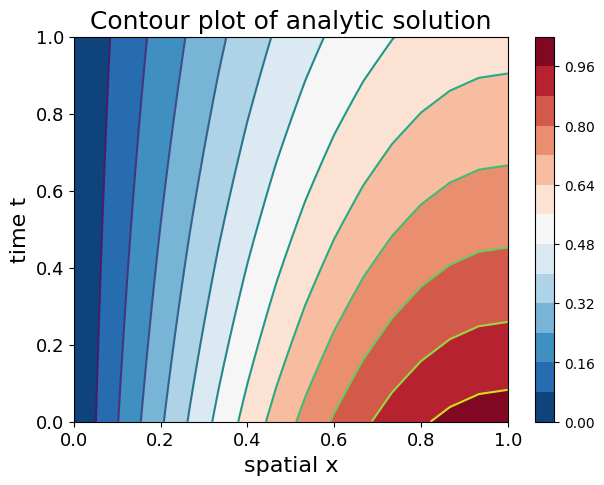

In [17]:
# 나중에 analytic - variational 오차율 구하라고 미리 contour plot 하나 만들어 본 것.
# xmesh, tmesh는 그대로일 거고 u_analytic function만 새로 넣으면 될 듯.
# https://m31phy.tistory.com/220
xmesh, tmesh = np.meshgrid(x_domain, t_domain)
zmesh = u_analytic(xmesh, tmesh)

plt.figure(figsize = (7, 5))
plt.contour(xmesh, tmesh, zmesh, levels = 15)
cntr = plt.contourf(xmesh, tmesh, zmesh, levels = 15, cmap = "RdBu_r")
plt.title("Contour plot of analytic solution", fontsize = 18)
plt.xlabel("spatial x", fontsize = 16)
plt.ylabel("time t", fontsize = 16)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.colorbar()
plt.show()

풀 문제: D=1/5인 [heat equation 풀기](https://tutorial.math.lamar.edu/classes/de/solvingheatequation.aspx)  
- 우리가 풀 범위는 $0\leq x\leq 1$, // $0\leq t\leq 1$. qubit 4개니까 x 범위는 16개로 쪼개질 거고 t는 20개로 쪼개자(x, t 범위 너무 작아서인지 analytic 구해보니 1e-5 order라 범위 키움. 논문에서도 범위 이렇게 잡음)  
- Boundary condition은 $u_0(x, 0)=\sin(\frac{\pi x}{2}),  u(0, t)=0, u(1, t)=1$로 두자.
- Normalization: $|u^k\rangle$ computational basis의 coefficient가 각 x point들에서의 u(x) 값. 그걸 normalize 한게 $|\psi(\theta)\rangle$. $|b^k\rangle$도 마찬가지.
- optimization 순서  
    1. eq 23대로 $|b^0\rangle=|u_0\rangle+\delta_x|u_D^{1}\rangle$ list 값을 f에 넣어서(normalize 자동으로 해줌) cost function 최적화. (이 과정에서 $r(\theta), |\psi(\theta)\rangle$ 따로 저장해주자.) 이때 $|u_0\rangle$의 amplitude는 $u_0(x, 0)$, $|u_D^{1}\rangle$은 $(u(0, t_1), 0,\dotsi, 0, u(1, t_1))$
    2. $b^1$은  $|u^1\rangle=r(\theta^0)|\psi(\theta^0)\rangle+\delta_x|u_D^{2}\rangle$
    3. 같은 방법으로 쭉 optimization ~~~
- plot: 우리 상황의 analytic solution인 $u(x, t)=\sin (\frac{\pi x}{2}) e^{-1/5(\frac{\pi}{2})^2 t}$과 비교하면 될 듯.  (하다가 잘 안되거나 넘 많으면 당근 개수 줄여도 됨)
    - plot1 수렴하는거 보여주기
    - plot2 analytic과 quantum 사이 오차율을 x축은 x, y축은 y인 contour plot으로 표현
    - plot3 t 고정시켜놓고 quantum과 analytic 비교(이왕이면 boundary 근처로 잘나오게)
    - plot4 x 고정시켜놓고 quantum과 analytic 비교(이왕이면 boundary 근처로 잘나오게)

## **Optimization**
---
- pennylane, variational algorithm 뭐 더 언어 있었는데 암튼 그런거 실행, plot

In [18]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev, interface="torch")
def circuit_state(weights):
  circuit(weights)
  return qml.state()

def solver(u_0):
  D = 1/5
  n_t = 20
  n_x = 16
  delta_x = D * (1/n_t)/((1/n_x)**2)
  u = [] * n_t 
  u_D = [ 0.0 ] * n_x
  u_D[ n_x-1 ] = 1.0
  itr = 100

  for i in range(n_t):
    b = u_0 + delta_x * np.array(u_D)
    for j in range(n_x):
      qnn_weights = 2 * np.pi * np.random.rand(n_qubits, n_qubits)
      qnn_weights = Variable(torch.tensor(qnn_weights), requires_grad=True)
      opt = torch.optim.Adam([qnn_weights], lr=0.1)
      for _ in range(itr):
        opt.zero_grad()
        loss = cost(qnn_weights, b, delta_x)
        loss.backward()
        opt.step()
    u.append(r(qnn_weights, b, delta_x)*circuit_state(qnn_weights))
    b = np.array(u[i].detach().numpy()) + np.array(delta_x * np.array(u_D))
  return u

print(solver(u_0))

ValueError: operands could not be broadcast together with shapes (41,) (16,) 